## Model

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
import keras_hub
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [4]:
# Tham số
IMG_SIZE = (224, 224)  # Điều chỉnh theo kích thước ảnh của bạn
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 15  # Thay đổi theo số lượng class thực tế

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)

# TRAIN_PATH='/kaggle/input/traffic-signs/dataset/train'
# VAL_PATH='/kaggle/input/traffic-signs/dataset/val'
# TEST_PATH='/kaggle/input/traffic-signs/dataset/test'
TRAIN_PATH='../dataset/classification/train'
VAL_PATH='../dataset/classification/val'
TEST_PATH='../dataset/classification/test'

In [5]:
# Tạo data generators
train_datagen = ImageDataGenerator(
    rescale=1./224,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./224)

# Tạo data loaders
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 52500 images belonging to 15 classes.
Found 11250 images belonging to 15 classes.
Found 11250 images belonging to 15 classes.


In [6]:
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.95,
    staircase=True
)

# Use the learning rate schedule in the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999)

In [7]:
checkpoint = ModelCheckpoint('best_model_v14.keras', monitor='val_loss', save_best_only=True, mode='min')

In [8]:
def create_model(num_classes=15, img_size=(224, 224)):
    # Load ResNet18 layers
    base_model = keras_hub.models.ResNetBackbone.from_preset("resnet_50_imagenet", num_classes=num_classes)
    # Freeze all layers
    base_model.trainable = False
    
    # Define input layer with specified image size
    inputs = tf.keras.layers.Input(shape=(224,224, 3))
    x = base_model(inputs, training=False)
    
    # Add custom layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create model
    model = tf.keras.models.Model(inputs, outputs)
    
    return model

In [9]:
model_path = '../model/best_resnet_v02.keras'

In [10]:
def load_model(model_path):
    model = tf.keras.models.load_model(model_path)
    return model

In [11]:
model = load_model(model_path)

D:\chientuhocai\Traffic_Sign\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 349 variables whereas the saved optimizer has 73 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net50v2_backbone            │ (None, 7, 7, 2048)     │    23,564,800 │
│ (ResNetV2Backbone)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │        30,735 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,695,726 (269.68 MB)

 Trainable params: 23,550,095 (89.84 MB)

 Non-trainable params: 45,440 (177.50 KB)

 Optimizer params: 47,100,191 (179.67 MB)

In [12]:
# Compile model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# print error on train and validation
train_loss, train_accuracy = model.evaluate(train_generator)
val_loss, val_accuracy = model.evaluate(val_generator)
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Train loss: {train_loss}, Train accuracy: {train_accuracy}')
print(f'Validation loss: {val_loss}, Validation accuracy: {val_accuracy}')
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

D:\chientuhocai\Traffic_Sign\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  39/1641 ━━━━━━━━━━━━━━━━━━━━ 1:26:19 3s/step - categorical_accuracy: 0.9764 - loss: 0.0791 - precision: 0.9842 - recall: 0.9744

KeyboardInterrupt: 

D:\chientuhocai\Traffic_Sign\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


352/352 ━━━━━━━━━━━━━━━━━━━━ 1117s 3s/step


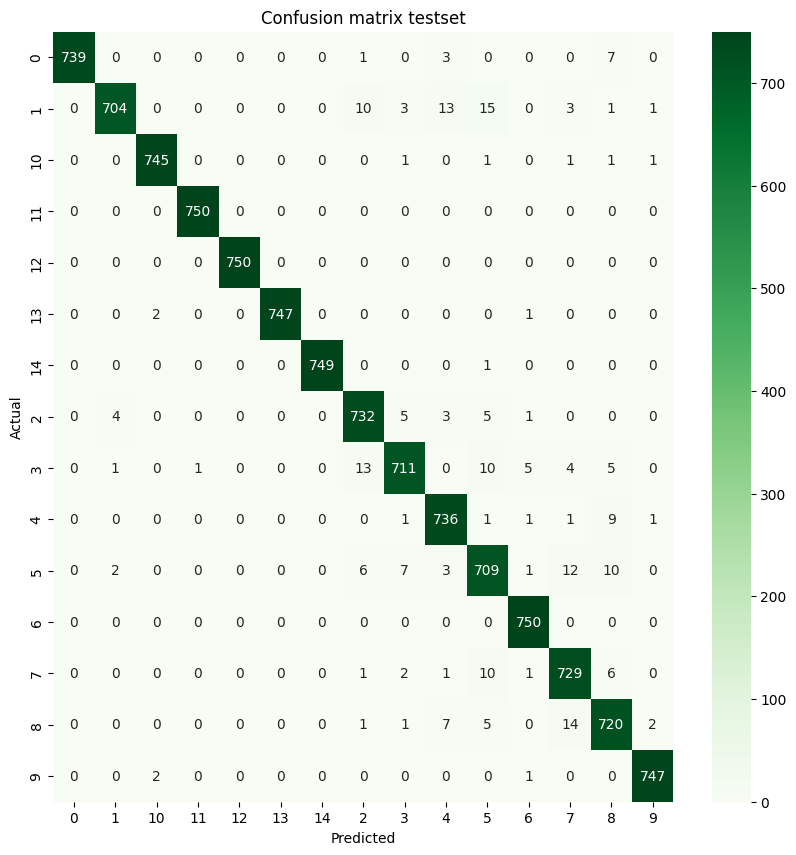

In [13]:
# Dự đoán
test_Y_pred = model.predict(test_generator)
test_y_pred = np.argmax(test_Y_pred, axis=1)

# Labels
test_labels = test_generator.class_indices
test_labels = dict((v, k) for k, v in test_labels.items())
test_predictions = [test_labels[k] for k in test_y_pred]

# Thực tế
test_y_test = test_generator.classes
test_true_labels = [test_labels[k] for k in test_y_test]

# Confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions, labels=list(test_labels.values()))
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(test_labels.values()), yticklabels=list(test_labels.values()),
            cmap='Greens')
plt.title('Confusion matrix testset')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [14]:
print(classification_report(test_true_labels, test_predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       750
           1       0.99      0.94      0.96       750
          10       0.99      0.99      0.99       750
          11       1.00      1.00      1.00       750
          12       1.00      1.00      1.00       750
          13       1.00      1.00      1.00       750
          14       1.00      1.00      1.00       750
           2       0.96      0.98      0.97       750
           3       0.97      0.95      0.96       750
           4       0.96      0.98      0.97       750
           5       0.94      0.95      0.94       750
           6       0.99      1.00      0.99       750
           7       0.95      0.97      0.96       750
           8       0.95      0.96      0.95       750
           9       0.99      1.00      0.99       750

    accuracy                           0.98     11250
   macro avg       0.98      0.98      0.98     11250
weighted avg       0.98   

D:\chientuhocai\Traffic_Sign\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


352/352 ━━━━━━━━━━━━━━━━━━━━ 1063s 3s/step


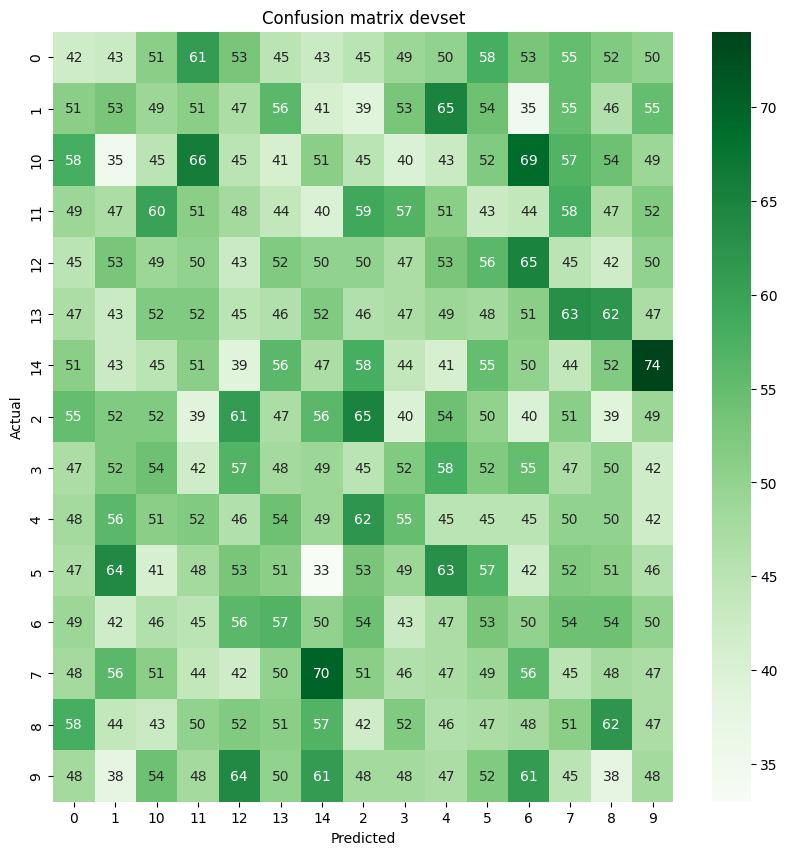

In [15]:
# Dự đoán
val_Y_pred = model.predict(val_generator)
val_y_pred = np.argmax(val_Y_pred, axis=1)

# Labels
val_labels = val_generator.class_indices
val_labels = dict((v, k) for k, v in val_labels.items())
val_predictions = [val_labels[k] for k in val_y_pred]

# Thực tế
val_y_test = val_generator.classes
val_true_labels = [val_labels[k] for k in val_y_test]

# Confusion matrix
cm = confusion_matrix(val_true_labels, val_predictions, labels=list(val_labels.values()))
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(val_labels.values()), yticklabels=list(val_labels.values()),
            cmap='Greens')
plt.title('Confusion matrix devset')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [16]:
print(classification_report(val_true_labels, val_predictions))

              precision    recall  f1-score   support

           0       0.06      0.06      0.06       750
           1       0.07      0.07      0.07       750
          10       0.06      0.06      0.06       750
          11       0.07      0.07      0.07       750
          12       0.06      0.06      0.06       750
          13       0.06      0.06      0.06       750
          14       0.06      0.06      0.06       750
           2       0.09      0.09      0.09       750
           3       0.07      0.07      0.07       750
           4       0.06      0.06      0.06       750
           5       0.07      0.08      0.07       750
           6       0.07      0.07      0.07       750
           7       0.06      0.06      0.06       750
           8       0.08      0.08      0.08       750
           9       0.06      0.06      0.06       750

    accuracy                           0.07     11250
   macro avg       0.07      0.07      0.07     11250
weighted avg       0.07   